In [1]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/4DCT/lib/pkgconfig'

In [2]:
import numpy as np
import scipy as sp
import fenics as fe
import fenics_adjoint as fa
from fenics import grad, dot, dx, ds
import torch
import torch_fenics
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import xarray as xr
import hvplot.xarray

--------------------------------------------------------------------------

  Local host:   dv002
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
class PDESolver(torch_fenics.FEniCSModule):
    
    def __init__(self, n_nodes=21):
        super().__init__()
        
        # create function space
        n_elements = n_nodes - 1
        mesh = fe.UnitIntervalMesh(n_elements)
        self.V = fe.FunctionSpace(mesh, 'P', 1)
        
        # create trial and test functions
        u = fe.TrialFunction(self.V)
        self.v = fe.TestFunction(self.V)
        
        # construct bilinear form
        self.a = fe.inner(fe.grad(u), fe.grad(self.v)) * fe.dx
        
    def solve(self, f, g):
        
        # construct linear form
        L = f * self.v * fe.dx
        
        # construct boundary condition
        bc = fa.DirichletBC(self.V, g, 'on_boundary')
        
        # solve the Poisson equation
        u = fa.Function(self.V)
        fa.solve(self.a == L, u, bc)
        
        return u
    
    def input_templates(self):
        return fa.Function(self.V), fa.Constant(0)

pde_solver = PDESolver()

In [14]:
%%time
print('solving forward problem')
N = 3
f = torch.rand(N, 21, requires_grad=True, dtype=torch.float64)
g = torch.zeros(N, 1, requires_grad=True, dtype=torch.float64)
u = pde_solver(f, g)
u.shape

solving forward problem
CPU times: user 11 ms, sys: 2.95 ms, total: 13.9 ms
Wall time: 14.1 ms


torch.Size([3, 21])

In [15]:
%%time
print('solving adjoint problem')
J = (u.abs()**2).sum()
J.backward()
dJdf = f.grad
dJdg = g.grad
dJdf.shape, dJdg.shape

solving adjoint problem
CPU times: user 55.7 ms, sys: 1 ms, total: 56.7 ms
Wall time: 57.5 ms


(torch.Size([3, 21]), torch.Size([3, 1]))

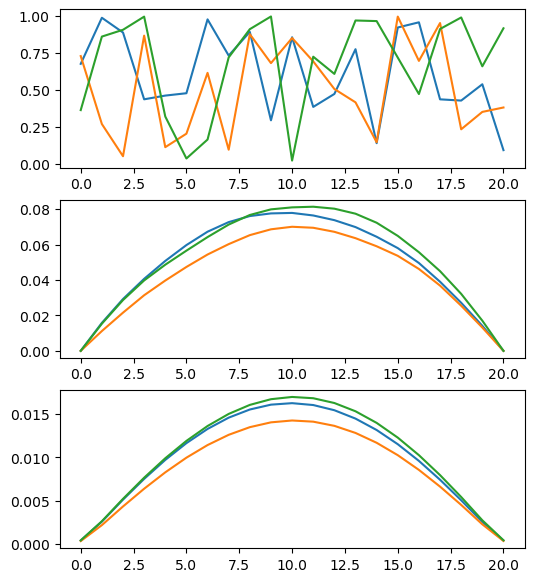

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

for i in range(N):
    ax[0].plot(f[i].detach().cpu().numpy())
    ax[1].plot(u[i].detach().cpu().numpy())
    ax[2].plot(dJdf[i].detach().cpu().numpy())

In [ ]:
%%time
f_pred = torch.rand(N, 21, requires_grad=True, dtype=torch.float64)

n_iterations = 100000
learning_rate = 0.1

for i in range(n_iterations+1):
    u_pred = pde_solver(f_pred, g)
    J = ((u_pred - u).abs()**2).sum()
    if (i+1)%10 == 0:
        print(i+1, J.item())
    if i == n_iterations:
        break
    J.backward()
    with torch.no_grad():
        f_pred = f_pred - learning_rate * f_pred.grad
    f_pred.requires_grad = True

10 0.010673718431014875
20 0.010256088013872646
30 0.009855195328379345
40 0.009470368958800345
50 0.00910096442388348
60 0.008746363096353306
70 0.008405971165750793
80 0.008079218642880026
90 0.0077655584041924864
100 0.007464465274506924
110 0.007175435146526953
120 0.006897984135680169
130 0.006631647768861742
140 0.00637598020572249
150 0.006130553491195837
160 0.005894956838010448
170 0.005668795937985652
180 0.005451692300955012
190 0.005243282620209647
200 0.005043218163397559
210 0.004851164187857653
220 0.004666799379408273
230 0.004489815313649332
240 0.004319915938874925
250 0.004156817079729444
260 0.004000245960775086
270 0.003849940749171929
280 0.00370565011570393
290 0.00356713281341487
300 0.0034341572731476635
310 0.0033065012153091935
320 0.003183951277209522
330 0.0030663026553508412
340 0.0029533587620663277
350 0.0028449308959334297
360 0.0027408379254087057
370 0.00264090598515421
380 0.0025449681845458403
390 0.0024528643278753934
400 0.002364440645776894
410 0

3060 0.00018058842447407815
3070 0.00018037307858778244
3080 0.0001801582541188876
3090 0.0001799439474144264
3100 0.00017973015492586724
3110 0.00017951687320503197
3120 0.00017930409890017142
3130 0.00017909182875220682
3140 0.00017888005959111364
3150 0.00017866878833245318
3160 0.00017845801197404712
3170 0.00017824772759277783
3180 0.00017803793234152126
3190 0.00017782862344620343
3200 0.00017761979820297166
3210 0.0001774114539754792
3220 0.000177203588192285
3230 0.00017699619834434508
3240 0.0001767892819826171
3250 0.00017658283671575365
3260 0.00017637686020788708
3270 0.00017617135017650995
3280 0.00017596630439043007
3290 0.0001757617206678177
3300 0.00017555759687432247
3310 0.00017535393092127184
3320 0.0001751507207639342
3330 0.0001749479643998619
3340 0.00017474565986729166
3350 0.0001745438052436099
3360 0.00017434239864388395
3370 0.00017414143821945028
3380 0.00017394092215655395
3390 0.00017374084867505192
3400 0.00017354121602715605
3410 0.0001733420224962406
342

6020 0.00013325493080672003
6030 0.00013313800877802639
6040 0.00013302131076976047
6050 0.00013290483624848088
6060 0.00013278858468207766
6070 0.00013267255553976837
6080 0.00013255674829209483
6090 0.00013244116241092197
6100 0.00013232579736942966
6110 0.00013221065264211384
6120 0.000132095727704782
6130 0.00013198102203454762
6140 0.00013186653510983062
6150 0.00013175226641035104
6160 0.00013163821541712766
6170 0.00013152438161247352
6180 0.0001314107644799915
6190 0.0001312973635045757
6200 0.00013118417817240265
6210 0.00013107120797093064
6220 0.0001309584523888981
6230 0.00013084591091631578
6240 0.00013073358304446946
6250 0.0001306214682659111
6260 0.00013050956607445956
6270 0.0001303978759651962
6280 0.00013028639743445998
6290 0.00013017512997984688
6300 0.0001300640731002071
6310 0.00012995322629563607
6320 0.00012984258906748066
6330 0.00012973216091832803
6340 0.00012962194135200615
6350 0.00012951192987358104
6360 0.00012940212598935174
6370 0.00012929252920684776


8970 0.0001065761149922107
8980 0.00010650688216766621
8990 0.00010643776178960077
9000 0.00010636875360191917
9010 0.0001062998573491582
9020 0.00010623107277648562
9030 0.0001061623996297007
9040 0.00010609383765522975
9050 0.00010602538660012506
9060 0.00010595704621206574
9070 0.00010588881623935275
9080 0.00010582069643091049
9090 0.00010575268653628236
9100 0.00010568478630563153
9110 0.00010561699548973843
9120 0.00010554931383999818
9130 0.00010548174110842063
9140 0.00010541427704762931
9150 0.0001053469214108571
9160 0.0001052796739519478
9170 0.0001052125344253513
9180 0.00010514550258612716
9190 0.00010507857818993704
9200 0.00010501176099304724
9210 0.00010494505075232589
9220 0.00010487844722524102
9230 0.00010481195016986028
9240 0.00010474555934484872
9250 0.00010467927450946666
9260 0.00010461309542356865
9270 0.00010454702184760394
9280 0.00010448105354261109
9290 0.0001044151902702189
9300 0.00010434943179264641
9310 0.00010428377787269783
9320 0.00010421822827376325

11920 9.011426477563683e-05
11930 9.006935137018571e-05
11940 9.002449665340043e-05
11950 8.997970050120168e-05
11960 8.993496278981248e-05
11970 8.989028339575822e-05
11980 8.984566219586289e-05
11990 8.980109906725016e-05
12000 8.97565938873432e-05
12010 8.971214653386135e-05
12020 8.966775688482342e-05
12030 8.962342481854253e-05
12040 8.957915021362884e-05
12050 8.953493294898669e-05
12060 8.949077290381534e-05
12070 8.944666995760561e-05
12080 8.940262399014434e-05
12090 8.935863488150714e-05
12100 8.931470251206239e-05
12110 8.927082676246951e-05
12120 8.922700751367652e-05
12130 8.918324464692016e-05
12140 8.913953804372786e-05
12150 8.909588758591197e-05
12160 8.905229315557345e-05
12170 8.900875463509867e-05
12180 8.896527190716035e-05
12190 8.892184485471475e-05
12200 8.887847336100294e-05
12210 8.883515730954875e-05
12220 8.879189658415947e-05
12230 8.874869106892397e-05
12240 8.870554064821184e-05
12250 8.866244520667361e-05
12260 8.861940462923944e-05
12270 8.8576418801119

14870 7.896550184946769e-05
14880 7.893359543894977e-05
14890 7.890172150706986e-05
14900 7.886987999274575e-05
14910 7.883807083503949e-05
14920 7.880629397315653e-05
14930 7.8774549346447e-05
14940 7.874283689440271e-05
14950 7.871115655665932e-05
14960 7.867950827299456e-05
14970 7.864789198332829e-05
14980 7.861630762772247e-05
14990 7.858475514637893e-05
15000 7.85532344796434e-05
15010 7.852174556799999e-05
15020 7.849028835207266e-05
15030 7.845886277262804e-05
15040 7.842746877057001e-05
15050 7.839610628694288e-05
15060 7.836477526292918e-05
15070 7.83334756398504e-05
15080 7.830220735916694e-05
15090 7.827097036247608e-05
15100 7.823976459151312e-05
15110 7.820858998815045e-05
15120 7.817744649439771e-05
15130 7.814633405240075e-05
15140 7.811525260444083e-05
15150 7.808420209293704e-05
15160 7.805318246044262e-05
15170 7.802219364964574e-05
15180 7.799123560337044e-05
15190 7.796030826457419e-05
15200 7.792941157634995e-05
15210 7.789854548192319e-05
15220 7.786770992465398e

17820 7.074168790192129e-05
17830 7.071722817971963e-05
17840 7.06927878936253e-05
17850 7.066836701274685e-05
17860 7.064396550626365e-05
17870 7.061958334342255e-05
17880 7.059522049354037e-05
17890 7.057087692600266e-05
17900 7.054655261026389e-05
17910 7.052224751584635e-05
17920 7.049796161234169e-05
17930 7.047369486940906e-05
17940 7.04494472567758e-05
17950 7.042521874423696e-05
17960 7.040100930165568e-05
17970 7.037681889896207e-05
17980 7.035264750615409e-05
17990 7.032849509329666e-05
18000 7.030436163052179e-05
18010 7.028024708802827e-05
18020 7.025615143608143e-05
18030 7.02320746450138e-05
18040 7.020801668522329e-05
18050 7.018397752717496e-05
18060 7.015995714139975e-05
18070 7.013595549849294e-05
18080 7.011197256911812e-05
18090 7.008800832400285e-05
18100 7.006406273393943e-05
18110 7.004013576978742e-05
18120 7.001622740246971e-05
18130 6.999233760297501e-05
18140 6.996846634235619e-05
18150 6.994461359173156e-05
18160 6.99207793222828e-05
18170 6.989696350525665e

20770 6.425679639886178e-05
20780 6.423697861323442e-05
20790 6.421717355101903e-05
20800 6.419738119590668e-05
20810 6.417760153162265e-05
20820 6.415783454192542e-05
20830 6.413808021060761e-05
20840 6.411833852149461e-05
20850 6.409860945844593e-05
20860 6.407889300535401e-05
20870 6.405918914614462e-05
20880 6.403949786477637e-05
20890 6.401981914524167e-05
20900 6.400015297156511e-05
20910 6.398049932780477e-05
20920 6.396085819805155e-05
20930 6.39412295664283e-05
20940 6.392161341709238e-05
20950 6.390200973423126e-05
20960 6.38824185020671e-05
20970 6.386283970485307e-05
20980 6.384327332687598e-05
20990 6.382371935245356e-05
21000 6.380417776593659e-05
21010 6.37846485517083e-05
21020 6.376513169418291e-05
21030 6.374562717780753e-05
21040 6.37261349870607e-05
21050 6.370665510645299e-05
21060 6.368718752052652e-05
21070 6.366773221385538e-05
21080 6.364828917104502e-05
21090 6.362885837673252e-05
21100 6.360943981558614e-05
21110 6.359003347230607e-05
21120 6.357063933162338e

23700 5.8935677801174186e-05
23710 5.891900890391809e-05
23720 5.890234910952978e-05
23730 5.888569840880685e-05
23740 5.886905679256408e-05
23750 5.885242425163283e-05
23760 5.883580077686102e-05
23770 5.881918635911361e-05
23780 5.880258098927185e-05
23790 5.878598465823364e-05
23800 5.8769397356913845e-05
23810 5.875281907624304e-05
23820 5.873624980716882e-05
23830 5.8719689540655055e-05
23840 5.87031382676819e-05
23850 5.868659597924625e-05
23860 5.867006266636094e-05
23870 5.865353832005503e-05
23880 5.8637022931373856e-05
23890 5.862051649137942e-05
23900 5.860401899114935e-05
23910 5.85875304217773e-05
23920 5.8571050774373874e-05
23930 5.8554580040064335e-05
23940 5.853811820999137e-05
23950 5.852166527531253e-05
23960 5.850522122720226e-05
23970 5.8488786056850144e-05
23980 5.8472359755461734e-05
23990 5.845594231425894e-05
24000 5.843953372447893e-05
24010 5.8423133977374625e-05
24020 5.84067430642146e-05
24030 5.839036097628412e-05
24040 5.8373987704882826e-05
24050 5.83576

26600 5.4450398003660366e-05
26610 5.4436040922290884e-05
26620 5.442169084488801e-05
26630 5.440734776580144e-05
26640 5.439301167938927e-05
26650 5.437868258001901e-05
26660 5.436436046206574e-05
26670 5.435004531991364e-05
26680 5.433573714795527e-05
26690 5.432143594059206e-05
26700 5.430714169223444e-05
26710 5.4292854397299975e-05
26720 5.42785740502156e-05
26730 5.4264300645416786e-05
26740 5.42500341773471e-05
26750 5.423577464045954e-05
26760 5.4221522029213525e-05
26770 5.4207276338079214e-05
26780 5.419303756153343e-05
26790 5.4178805694062454e-05
26800 5.416458073016001e-05
26810 5.415036266432924e-05
26820 5.413615149108045e-05
26830 5.412194720493318e-05
26840 5.4107749800414535e-05
26850 5.409355927206031e-05
26860 5.407937561441481e-05
26870 5.406519882202943e-05
26880 5.4051028889464824e-05
26890 5.4036865811290124e-05
26900 5.402270958208126e-05
26910 5.40085601964238e-05
26920 5.399441764891042e-05
26930 5.3980281934142083e-05
26940 5.3966153046728324e-05
26950 5.395

29500 5.055983050624844e-05
29510 5.0547297782552796e-05
29520 5.053477072174186e-05
29530 5.052224932003272e-05
29540 5.050973357364658e-05
29550 5.0497223478810545e-05
29560 5.048471903175487e-05
29570 5.047222022871522e-05
29580 5.045972706593195e-05
29590 5.044723953965027e-05
29600 5.043475764611941e-05
29610 5.0422281381592755e-05
29620 5.0409810742330094e-05
29630 5.039734572459441e-05
29640 5.038488632465317e-05
29650 5.0372432538778826e-05
29660 5.0359984363248706e-05
29670 5.034754179434407e-05
29680 5.0335104828351496e-05
29690 5.032267346156084e-05
29700 5.031024769026793e-05
29710 5.0297827510772114e-05
29720 5.0285412919377615e-05
29730 5.027300391239279e-05
29740 5.02606004861314e-05
29750 5.02482026369109e-05
29760 5.023581036105309e-05
29770 5.0223423654884845e-05
29780 5.0211042514736744e-05
29790 5.0198666936945005e-05
29800 5.018629691784896e-05
29810 5.0173932453793184e-05
29820 5.016157354112621e-05
29830 5.014922017620181e-05
29840 5.013687235537636e-05
29850 5.0

32410 4.713760178496742e-05
32420 4.712657390951974e-05
32430 4.711555076070456e-05
32440 4.710453233577789e-05
32450 4.709351863199883e-05
32460 4.708250964662836e-05
32470 4.707150537693172e-05
32480 4.706050582017541e-05
32490 4.704951097362897e-05
32500 4.7038520834564766e-05
32510 4.7027535400257856e-05
32520 4.701655466798584e-05
32530 4.700557863502928e-05
32540 4.699460729867071e-05
32550 4.6983640656195785e-05
32560 4.697267870489275e-05
32570 4.69617214420525e-05
32580 4.6950768864968575e-05
32590 4.693982097093663e-05
32600 4.692887775725595e-05
32610 4.6917939221227496e-05
32620 4.690700536015538e-05
32630 4.6896076171345964e-05
32640 4.6885151652108415e-05
32650 4.687423179975433e-05
32660 4.6863316611598594e-05
32670 4.6852406084957535e-05
32680 4.684150021715064e-05
32690 4.683059900550027e-05
32700 4.681970244733089e-05
32710 4.6808810539969984e-05
32720 4.679792328074675e-05
32730 4.678704066699407e-05
32740 4.6776162696046455e-05
32750 4.6765289365241556e-05
32760 4.6

35320 4.411749253541683e-05
35330 4.410773404024305e-05
35340 4.409797957021319e-05
35350 4.408822912320297e-05
35360 4.407848269708995e-05
35370 4.406874028975373e-05
35380 4.4059001899075264e-05
35390 4.404926752293698e-05
35400 4.403953715922307e-05
35410 4.402981080581954e-05
35420 4.402008846061442e-05
35430 4.401037012149639e-05
35440 4.40006557863571e-05
35450 4.399094545308842e-05
35460 4.39812391195849e-05
35470 4.39715367837426e-05
35480 4.3961838443458753e-05
35490 4.395214409663271e-05
35500 4.394245374116522e-05
35510 4.393276737495901e-05
35520 4.392308499591787e-05
35530 4.391340660194773e-05
35540 4.390373219095604e-05
35550 4.389406176085145e-05
35560 4.3884395309545015e-05
35570 4.387473283494877e-05
35580 4.386507433497675e-05
35590 4.385541980754449e-05
35600 4.384576925056877e-05
35610 4.383612266196868e-05
35620 4.382648003966457e-05
35630 4.381684138157859e-05
35640 4.3807206685633705e-05
35650 4.379757594975544e-05
35660 4.3787949171870787e-05
35670 4.3778326349

38230 4.1439430821561864e-05
38240 4.14307601943435e-05
38250 4.1422093036282885e-05
38260 4.1413429345658254e-05
38270 4.1404769120749685e-05
38280 4.139611235983729e-05
38290 4.138745906120313e-05
38300 4.1378809223130077e-05
38310 4.137016284390245e-05
38320 4.136151992180533e-05
38330 4.135288045512498e-05
38340 4.1344244442148884e-05
38350 4.133561188116589e-05
38360 4.1326982770465455e-05
38370 4.1318357108338736e-05
38380 4.130973489307755e-05
38390 4.130111612297516e-05
38400 4.129250079632574e-05
38410 4.1283888911424446e-05
38420 4.127528046656833e-05
38430 4.126667546005476e-05
38440 4.125807389018188e-05
38450 4.1249475755250365e-05
38460 4.124088105356098e-05
38470 4.123228978341566e-05
38480 4.1223701943117504e-05
38490 4.1215117530971125e-05
38500 4.120653654528167e-05
38510 4.119795898435589e-05
38520 4.1189384846501185e-05
38530 4.1180814130026546e-05
38540 4.117224683324161e-05
38550 4.1163682954457444e-05
38560 4.115512249198614e-05
38570 4.1146565444140785e-05
38580

41140 3.9055974755994445e-05
41150 3.90482452950615e-05
41160 3.904051884565888e-05
41170 3.903279540634993e-05
41180 3.902507497569754e-05
41190 3.901735755226683e-05
41200 3.900964313462255e-05
41210 3.900193172133156e-05
41220 3.899422331096033e-05
41230 3.898651790207697e-05
41240 3.897881549324997e-05
41250 3.897111608304911e-05
41260 3.8963419670044456e-05
41270 3.895572625280747e-05
41280 3.8948035829910206e-05
41290 3.8940348399925395e-05
41300 3.893266396142657e-05
41310 3.8924982512988145e-05
41320 3.8917304053185956e-05
41330 3.8909628580595834e-05
41340 3.890195609379499e-05
41350 3.8894286591360965e-05
41360 3.888662007187271e-05
41370 3.887895653390945e-05
41380 3.8871295976051333e-05
41390 3.886363839687977e-05
41400 3.8855983794976825e-05
41410 3.8848332168925034e-05
41420 3.884068351730803e-05
41430 3.883303783871e-05
41440 3.882539513171662e-05
41450 3.881775539491352e-05
41460 3.881011862688788e-05
41470 3.880248482622711e-05
41480 3.8794853991519876e-05
41490 3.8787

44050 3.6928164836990245e-05
44060 3.6921254292678556e-05
44070 3.6914346374253714e-05
44080 3.6907441080495e-05
44090 3.690053841018119e-05
44100 3.68936383620923e-05
44110 3.6886740935009106e-05
44120 3.6879846127712556e-05
44130 3.6872953938984664e-05
44140 3.686606436760809e-05
44150 3.685917741236566e-05
44160 3.685229307204152e-05
44170 3.684541134542009e-05
44180 3.6838532231286565e-05
44190 3.68316557284265e-05
44200 3.682478183562674e-05
44210 3.681791055167411e-05
44220 3.6811041875356315e-05
44230 3.6804175805461886e-05
44240 3.679731234077975e-05
44250 3.6790451480099825e-05
44260 3.678359322221224e-05
44270 3.67767375659082e-05
44280 3.676988450997896e-05
44290 3.676303405321706e-05
44300 3.6756186194415583e-05
44310 3.674934093236785e-05
44320 3.6742498265868176e-05
44330 3.673565819371154e-05
44340 3.672882071469329e-05
44350 3.6721985827609686e-05
44360 3.6715153531257244e-05
44370 3.670832382443365e-05
44380 3.670149670593727e-05
44390 3.669467217456621e-05
44400 3.668

46960 3.5023215283244715e-05
46970 3.5017019868068854e-05
46980 3.501082674920326e-05
46990 3.500463592559964e-05
47000 3.499844739620911e-05
47010 3.499226115998423e-05
47020 3.498607721587694e-05
47030 3.497989556284114e-05
47040 3.497371619982967e-05
47050 3.496753912579733e-05
47060 3.4961364339698717e-05
47070 3.495519184048887e-05
47080 3.494902162712397e-05
47090 3.494285369855998e-05
47100 3.493668805375425e-05
47110 3.49305246916638e-05
47120 3.492436361124648e-05
47130 3.491820481146099e-05
47140 3.491204829126618e-05
47150 3.4905894049621695e-05
47160 3.489974208548766e-05
47170 3.489359239782443e-05
47180 3.488744498559303e-05
47190 3.488129984775569e-05
47200 3.487515698327365e-05
47210 3.4869016391110414e-05
47220 3.486287807022897e-05
47230 3.4856742019592966e-05
47240 3.485060823816664e-05
47250 3.484447672491497e-05
47260 3.4838347478803226e-05
47270 3.4832220498797126e-05
47280 3.482609578386306e-05
47290 3.4819973332968247e-05
47300 3.4813853145079824e-05
47310 3.480

49860 3.3318700840700505e-05
49870 3.331312945641694e-05
49880 3.3307560085370957e-05
49890 3.330199272665553e-05
49900 3.329642737936379e-05
49910 3.329086404259069e-05
49920 3.328530271542976e-05
49930 3.3279743396976e-05
49940 3.327418608632489e-05
49950 3.3268630782572145e-05
49960 3.3263077484814094e-05
49970 3.325752619214733e-05
49980 3.3251976903668715e-05
49990 3.3246429618475906e-05
50000 3.3240884335667e-05
50010 3.323534105434035e-05
50020 3.322979977359496e-05
50030 3.3224260492530045e-05
50040 3.321872321024545e-05
50050 3.3213187925841184e-05
50060 3.320765463841825e-05
50070 3.320212334707734e-05
50080 3.319659405092043e-05
50090 3.3191066749049065e-05
50100 3.318554144056612e-05
50110 3.318001812457392e-05
50120 3.317449680017659e-05
50130 3.3168977466477244e-05
50140 3.316346012258033e-05
50150 3.315794476759026e-05
50160 3.3152431400612394e-05
50170 3.314692002075207e-05
50180 3.3141410627115494e-05
50190 3.313590321880896e-05
50200 3.313039779493935e-05
50210 3.3124

52760 3.178384096854238e-05
52770 3.1778817150886134e-05
52780 3.177379510126669e-05
52790 3.1768774818897246e-05
52800 3.176375630299106e-05
52810 3.175873955276221e-05
52820 3.1753724567424796e-05
52830 3.174871134619339e-05
52840 3.174369988828297e-05
52850 3.173869019290897e-05
52860 3.173368225928718e-05
52870 3.172867608663353e-05
52880 3.172367167416471e-05
52890 3.171866902109755e-05
52900 3.1713668126648976e-05
52910 3.170866899003744e-05
52920 3.1703671610480355e-05
52930 3.169867598719633e-05
52940 3.1693682119403946e-05
52950 3.168869000632248e-05
52960 3.168369964717136e-05
52970 3.1678711041170764e-05
52980 3.1673724187540766e-05
52990 3.166873908550247e-05
53000 3.166375573427607e-05
53010 3.165877413308381e-05
53020 3.1653794281147056e-05
53030 3.1648816177688123e-05
53040 3.16438398219297e-05
53050 3.1638865213094323e-05
53060 3.1633892350405686e-05
53070 3.162892123308735e-05
53080 3.1623951860363355e-05
53090 3.1618984231458224e-05
53100 3.161401834559669e-05
53110 3

55660 3.0397964614297188e-05
55670 3.0393422029673248e-05
55680 3.038888100008559e-05
55690 3.0384341524849697e-05
55700 3.037980360328174e-05
55710 3.037526723469798e-05
55720 3.0370732418415202e-05
55730 3.0366199153750322e-05
55740 3.0361667440020986e-05
55750 3.0357137276544455e-05
55760 3.0352608662638804e-05
55770 3.0348081597622398e-05
55780 3.0343556080814287e-05
55790 3.0339032111532612e-05
55800 3.0334509689097322e-05
55810 3.0329988812827974e-05
55820 3.0325469482044365e-05
55830 3.0320951696066654e-05
55840 3.0316435454215796e-05
55850 3.0311920755812288e-05
55860 3.030740760017771e-05
55870 3.0302895986633705e-05
55880 3.029838591450204e-05
55890 3.029387738310472e-05
55900 3.028937039176452e-05
55910 3.028486493980436e-05
55920 3.0280361026547438e-05
55930 3.027585865131694e-05
55940 3.0271357813437193e-05
55950 3.0266858512232135e-05
55960 3.026236074702622e-05
55970 3.02578645171444e-05
55980 3.0253369821911918e-05
55990 3.0248876660653697e-05
56000 3.024438503269598e-0

58520 2.9159607742712227e-05
58530 2.915548323000871e-05
58540 2.9151360089367465e-05
58550 2.9147238320191436e-05
58560 2.914311792188411e-05
58570 2.9138998893848853e-05
58580 2.913488123548908e-05
58590 2.913076494620967e-05
58600 2.912665002541441e-05
58610 2.912253647250832e-05
58620 2.911842428689591e-05
58630 2.911431346798281e-05
58640 2.9110204015174276e-05
58650 2.9106095927876237e-05
58660 2.910198920549454e-05
58670 2.9097883847436e-05
58680 2.909377985310661e-05
58690 2.9089677221913875e-05
58700 2.908557595326474e-05
58710 2.9081476046566494e-05
58720 2.9077377501227116e-05
58730 2.9073280316654726e-05
58740 2.9069184492257506e-05
58750 2.906509002744407e-05
58760 2.906099692162336e-05
58770 2.9056905174204445e-05
58780 2.905281478459672e-05
58790 2.904872575221013e-05
58800 2.9044638076454675e-05
58810 2.9040551756740354e-05
58820 2.903646679247786e-05
58830 2.9032383183078162e-05
58840 2.9028300927952313e-05
58850 2.9024220026511576e-05
58860 2.9020140478167883e-05
5887

61390 2.8029931926554202e-05
61400 2.8026177759966183e-05
61410 2.802242480519415e-05
61420 2.80186730617174e-05
61430 2.801492252901463e-05
61440 2.801117320656524e-05
61450 2.800742509384866e-05
61460 2.8003678190344875e-05
61470 2.7999932495533715e-05
61480 2.799618800889559e-05
61490 2.7992444729911188e-05
61500 2.7988702658060924e-05
61510 2.7984961792826007e-05
61520 2.7981222133687904e-05
61530 2.7977483680127593e-05
61540 2.79737464316272e-05
61550 2.797001038766888e-05
61560 2.7966275547734443e-05
61570 2.7962541911306814e-05
61580 2.7958809477868262e-05
61590 2.795507824690205e-05
61600 2.7951348217891324e-05
61610 2.7947619390319543e-05
61620 2.7943891763670567e-05
61630 2.7940165337428285e-05
61640 2.7936440111076575e-05
61650 2.793271608409998e-05
61660 2.7928993255983586e-05
61670 2.7925271626211887e-05
61680 2.7921551194270377e-05
61690 2.7917831959643925e-05
61700 2.7914113921818997e-05
61710 2.791039708028075e-05
61720 2.790668143451547e-05
61730 2.7902966984009824e-05

64260 2.7000254416043272e-05
64270 2.6996827576719644e-05
64280 2.6993401809267357e-05
64290 2.698997711323198e-05
64300 2.6986553488157307e-05
64310 2.698313093358914e-05
64320 2.6979709449072508e-05
64330 2.6976289034152834e-05
64340 2.6972869688375832e-05
64350 2.6969451411287638e-05
64360 2.696603420243419e-05
64370 2.696261806136212e-05
64380 2.6959202987617733e-05
64390 2.695578898074796e-05
64400 2.695237604029973e-05
64410 2.694896416582029e-05
64420 2.6945553356856986e-05
64430 2.6942143612957498e-05
64440 2.6938734933669774e-05
64450 2.6935327318541847e-05
64460 2.693192076712177e-05
64470 2.692851527895842e-05
64480 2.6925110853600012e-05
64490 2.692170749059586e-05
64500 2.6918305189494934e-05
64510 2.691490394984648e-05
64520 2.691150377120026e-05
64530 2.6908104653105752e-05
64540 2.6904706595113175e-05
64550 2.6901309596772574e-05
64560 2.6897913657634328e-05
64570 2.6894518777248844e-05
64580 2.6891124955167284e-05
64590 2.688773219094053e-05
64600 2.688434048411996e-05

67130 2.605902441488226e-05
67140 2.605588731980622e-05
67150 2.6052751174293578e-05
67160 2.604961597794628e-05
67170 2.604648173036636e-05
67180 2.604334843115634e-05
67190 2.604021607991851e-05
67200 2.6037084676255447e-05
67210 2.603395421976991e-05
67220 2.603082471006513e-05
67230 2.6027696146744078e-05
67240 2.602456852941044e-05
67250 2.60214418576674e-05
67260 2.601831613111899e-05
67270 2.601519134936894e-05
67280 2.60120675120215e-05
67290 2.6008944618680906e-05
67300 2.6005822668951657e-05
67310 2.600270166243857e-05
67320 2.5999581598746247e-05
67330 2.5996462477479855e-05
67340 2.5993344298244564e-05
67350 2.5990227060645846e-05
67360 2.598711076428927e-05
67370 2.5983995408780608e-05
67380 2.598088099372586e-05
67390 2.5977767518731156e-05
67400 2.59746549834028e-05
67410 2.5971543387347297e-05
67420 2.5968432730171157e-05
67430 2.5965323011481643e-05
67440 2.5962214230885652e-05
67450 2.595910638799035e-05
67460 2.5955999482403096e-05
67470 2.595289351373189e-05
67480 2

70000 2.5196147042783457e-05
70010 2.5193266833923552e-05
70020 2.519038746765683e-05
70030 2.51875089436357e-05
70040 2.518463126151142e-05
70050 2.518175442093618e-05
70060 2.517887842156217e-05
70070 2.5176003263041795e-05
70080 2.5173128945027556e-05
70090 2.5170255467171988e-05
70100 2.516738282912822e-05
70110 2.5164511030548873e-05
70120 2.5161640071087216e-05
70130 2.5158769950396526e-05
70140 2.5155900668130333e-05
70150 2.5153032223942544e-05
70160 2.5150164617486277e-05
70170 2.514729784841605e-05
70180 2.5144431916385715e-05
70190 2.514156682104953e-05
70200 2.5138702562062186e-05
70210 2.513583913907793e-05
70220 2.5132976551751803e-05
70230 2.513011479973874e-05
70240 2.512725388269374e-05
70250 2.5124393800271542e-05
70260 2.5121534552128025e-05
70270 2.511867613791894e-05
70280 2.511581855729966e-05
70290 2.5112961809926153e-05
70300 2.5110105895454286e-05
70310 2.5107250813540634e-05
70320 2.5104396563841012e-05
70330 2.5101543146012618e-05
70340 2.509869055971142e-05


72870 2.440279353999549e-05
72880 2.4400141470111393e-05
72890 2.439749014919989e-05
72900 2.439483957695584e-05
72910 2.4392189753074547e-05
72920 2.438954067725121e-05
72930 2.4386892349181513e-05
72940 2.4384244768560904e-05
72950 2.4381597935085186e-05
72960 2.4378951848450322e-05
72970 2.4376306508352202e-05
72980 2.4373661914487233e-05
72990 2.43710180665514e-05
73000 2.4368374964241424e-05
73010 2.4365732607253756e-05
73020 2.4363090995284926e-05
73030 2.43604501280325e-05
73040 2.4357810005192708e-05
73050 2.4355170626463187e-05
73060 2.4352531991540972e-05
73070 2.4349894100123617e-05
73080 2.4347256951908687e-05
73090 2.434462054659374e-05
73100 2.4341984883876944e-05
73110 2.43393499634562e-05
73120 2.433671578502938e-05
73130 2.433408234829498e-05
73140 2.4331449652951312e-05
73150 2.432881769869701e-05
73160 2.4326186485230545e-05
73170 2.432355601225107e-05
73180 2.4320926279457515e-05
73190 2.4318297286548602e-05
73200 2.4315669033223834e-05
73210 2.4313041519182717e-05


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

for i in range(N):
    ax[0,0].plot(f[i].detach().cpu().numpy())
    ax[0,1].plot(u[i].detach().cpu().numpy())
    ax[1,0].plot(f_pred[i].detach().cpu().numpy())
    ax[1,1].plot(u_pred[i].detach().cpu().numpy())

## Adjoint method derivation

A PDE constraint implicitly defines $\mathbf{u}(\mu)$:
$$
\begin{align*}
    \mathbf{r}(\mathbf{u};\mu) = 0
\end{align*}
$$

Loss function
$$
\begin{align*}
    L(\mathbf{u},\mu)
\end{align*}
$$

Loss gradient
$$
\begin{align*}
    dL &= \frac{\partial L}{\partial \mu} d\mu + \frac{\partial L}{\partial \mathbf{u}} d \mathbf{u} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \mathbf{u}} \frac{d\mathbf{u}}{d\mu}
\end{align*}
$$

Assume that $\mathbf{r} = 0$
$$
\begin{align*}
    d\mathbf{r} &= 0 \\ 
    \frac{\partial \bf r}{\partial \bf u} d\mathbf{u} + \frac{\partial \bf r}{\partial \mu} d\mu &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} + \frac{\partial \bf r}{\partial \mu} &= 0 \\
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \mu} \\
    \frac{d \bf u}{d \mu} &= -\frac{\partial \bf r}{\partial \bf u}^{-1} \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

This result is part of the implicit function theorem.

Then:
$$
\begin{align*}
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} + \frac{\partial L}{\partial \bf u} \frac{d \bf u}{d \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \left( \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \right) \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \left( \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \right) \frac{\partial \bf r}{\partial \mu} \\
\end{align*}
$$

Direct method:

$$
\begin{align*}
    \Phi &= \frac{\partial \bf r}{\partial \bf u} ^{-1} \frac{\partial \bf r}{\partial \mu} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \frac{\partial L}{\partial \bf u} \Phi \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u} \Phi &= \frac{\partial \bf r}{\partial \mu}
\end{align*}
$$

Adjoint method:

$$
\begin{align*}
    \Psi^\top &= \frac{\partial L}{\partial \bf u} \frac{\partial \bf r}{\partial \bf u} ^{-1} \\
    \frac{dL}{d\mu} &= \frac{\partial L}{\partial \mu} - \Psi^\top \frac{\partial \bf r}{\partial \mu} \\
    \operatorname{solve} \, \frac{\partial \bf r}{\partial \bf u}^\top \Psi &= \frac{\partial L}{\partial \bf u}^\top
\end{align*}
$$

In either case, the output is $\frac{d L}{d \mu}$.

In [ ]:
class ImplicitPDELayer(object):

    def forward(self, mu):
        u = solve_pde(mu)
        return u

    def backward(self, dL_du, dL_dmu, dr_du, dr_dmu, method='adjoint'):
    
        if method == 'direct':
            phi = torch.linalg.solve(dr_du, dr_dmu)
            grad = dL_dmu - dL_du @ phi
    
        elif method == 'adjoint':
            psi = torch.linalg.solve(dr_du.T, dL_du.T)
            grad = dL_dmu - psi.T @ dr_dmu
            
        return grad
